# Práctica Calificada 2
## Predicción de tarifas de taxis
El objetivo de esta evaluación es construir un modelo de aprendizaje que sea capaz de predecir la tarifa que cobra un taxi de acuerdo a cierta información de entrada.


In [11]:
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
print("Pandas = ", pd.__version__)
print("Numpy = ", np.__version__)

Pandas =  1.1.5
Numpy =  1.19.5


# Obteniendo del conjunto de datos

In [12]:
pd.read_csv("./train.csv",nrows=5).head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Tenemos las siguientes columnas

*   key: cadena que identifica de manera única a cada registro.
*   fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir.
*   pickup_datetime: timestamp indicando cuando el viaje a empezado.
*   pickup_longitude: número real indicando la ubicación en longitud en donde el viaje empezó.
*   pickup_latitude: número real indicando la ubicación en latitud en donde el viaje empezó.
*   dropoff_longitude: número real indicando la ubicación en longitud en donde el viaje terminó.
*   dropoff_latitude: número real indicando la ubicación en latitud en donde el viaje terminó.
*   passenger_count: número entero indicando el número de pasajeros en el servicio de taxi.

*La columna key no es un caracterísitica que nos interese.*

**Cargamos solo las columnas que nos interesan**

In [13]:
columns = ["fare_amount","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count"]

In [14]:
df_train = pd.read_csv("./train.csv",nrows=20000000,usecols=columns)

**Uso total de la memoria al inicio**

In [15]:
memoria_inicial = df_train.memory_usage(deep=True).sum()
print(f"{memoria_inicial/1e9:0.2f}GB")

2.56GB


**Analizando el tipo de las variables**

In [16]:
df_train.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

Uso de memoria de cada columna en bytes.

In [17]:
df_train.memory_usage(deep=True)

Index                       128
fare_amount           160000000
pickup_datetime      1600000000
pickup_longitude      160000000
pickup_latitude       160000000
dropoff_longitude     160000000
dropoff_latitude      160000000
passenger_count       160000000
dtype: int64

**Utilizando tipos de datos eficientes.**

In [18]:
df_train["passenger_count"] = pd.to_numeric(df_train["passenger_count"], downcast="unsigned")
df_train["fare_amount"] =  pd.to_numeric(df_train["fare_amount"], downcast="float")
df_train[["pickup_longitude","pickup_latitude"]] = df_train[["pickup_longitude","pickup_latitude"]].apply(pd.to_numeric, downcast="float")
df_train[["dropoff_longitude","dropoff_latitude"]] = df_train[["dropoff_longitude","dropoff_latitude"]].apply(pd.to_numeric, downcast="float")

In [19]:
df_train.dtypes

fare_amount          float32
pickup_datetime       object
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count        uint8
dtype: object

Uso de memoria de cada columna en bytes luego de utilizar tipos de datos más eficientes.

In [20]:
df_train.memory_usage(deep=True)

Index                       128
fare_amount            80000000
pickup_datetime      1600000000
pickup_longitude       80000000
pickup_latitude        80000000
dropoff_longitude      80000000
dropoff_latitude       80000000
passenger_count        20000000
dtype: int64

Uso de memoria total luego de utilizar tipos de datos más eficientes.

In [21]:
memoria_final = df_train.memory_usage(deep=True).sum()
print(f"{memoria_final/1e9:0.2f}GB")

2.02GB


**Reducción de Memoria**

In [22]:
reduccion = (memoria_inicial-memoria_final)/memoria_inicial*100
print(f"Reducimos el uso de memoria en {reduccion:0.2f}%")

Reducimos el uso de memoria en 21.09%


In [23]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+07,2.000000e+07,2.000000e+07,1.999986e+07,1.999986e+07,2.000000e+07
mean,1.112807e+01,-7.605276e+01,4.304310e+01,-7.605211e+01,4.304116e+01,1.685312e+00
std,1.665027e+01,1.333575e+01,9.634870e+00,1.325502e+01,9.805292e+00,1.321177e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.442025e+03,-3.493652e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396709e+01,4.076712e+01,-7.396368e+01,4.076809e+01,2.000000e+00
max,6.155086e+04,3.457626e+03,3.406008e+03,3.457622e+03,3.400392e+03,2.080000e+02


In [24]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 7 columns):
 #   Column             Non-Null Count     Dtype  
---  ------             --------------     -----  
 0   fare_amount        20000000 non-null  float32
 1   pickup_datetime    20000000 non-null  object 
 2   pickup_longitude   20000000 non-null  float32
 3   pickup_latitude    20000000 non-null  float32
 4   dropoff_longitude  19999861 non-null  float32
 5   dropoff_latitude   19999861 non-null  float32
 6   passenger_count    20000000 non-null  uint8  
dtypes: float32(5), object(1), uint8(1)
memory usage: 553.1+ MB


De lo anterior se puede observar que tenemos valores nulos, entonces verificamos cuando valores nulos hay por cada columna:

In [25]:
print(df_train.isnull().sum())

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    139
dropoff_latitude     139
passenger_count        0
dtype: int64


In [26]:
# Eliminando
df_train = df_train.dropna(how='any', axis=0)

# Analizando Fare_amount

In [27]:
df_train[['fare_amount']].describe()

,fare_amount
count,1.999986e+07
mean,1.112802e+01
std,1.665029e+01
min,-1.077500e+02
25%,6.000000e+00
50%,8.500000e+00
75%,1.250000e+01
max,6.155086e+04


Analizaremos las columnas de df_train para encontrar valores atípicos.

Analizamos gráficamente la columna "fare_amount".

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef30d6c410>]],
      dtype=object)

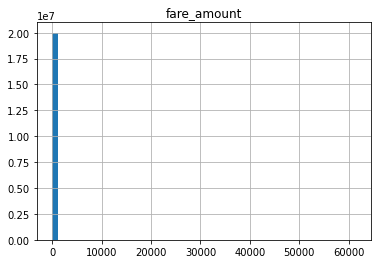

In [28]:
df_train.hist(column='fare_amount',bins=50)

Observamos una gran concentración de datos para los valores más pequeños de fare_amount. Acercamos la gráfica para poder distinguir mejor estos valores.

(-10.0, 400.0)

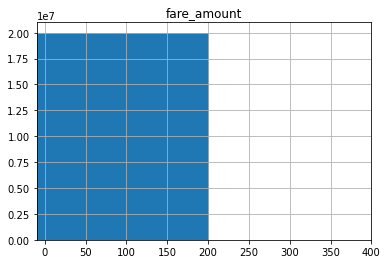

In [29]:
df_train.hist(column='fare_amount',bins=200)

plot.xlim(-10,400)

Podemos observar que los valores más significativos se encuentran entre 0 y 100 

Obervamos que el el minimo del monto de tarifa es negativo, veamos cuantos montos de tarifa menores o iguales a cero y mayores de 100 tenemos: 

In [30]:
len(df_train[df_train['fare_amount'] <= 0].index)

1357

In [31]:
len(df_train[df_train['fare_amount'] > 100].index)

7620

In [32]:
df_train[df_train['fare_amount'] <= 0]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.9,2010-03-09 23:37:10 UTC,-73.789452,40.643497,-73.788666,40.641953,1
2486,-2.5,2015-03-22 05:14:27 UTC,-74.000031,40.720631,-73.999809,40.720539,1
10002,0.0,2010-02-15 14:26:01 UTC,-73.987114,40.738808,-74.005913,40.713959,1
13032,-3.0,2013-08-30 08:57:10 UTC,-73.995064,40.740753,-73.995888,40.741356,4
27891,0.0,2015-05-15 21:40:28 UTC,-74.077927,40.805714,-74.077919,40.805721,1
...,...,...,...,...,...,...,...
19970522,-2.5,2013-08-19 03:10:10 UTC,-73.937859,40.757851,-73.937859,40.757851,1
19971587,0.0,2015-02-21 11:59:26 UTC,-73.937630,40.758221,-73.937630,40.758221,1
19971904,0.0,2010-02-15 17:02:14 UTC,-73.808792,40.689507,-73.972588,40.757427,1
19979348,-2.5,2015-05-24 19:18:38 UTC,-73.963982,40.761410,-73.965370,40.761791,1


Solo queremos los datos donde el monto de la tarifa sea mayor que cero y menor que 100:

In [33]:
df_train = df_train[df_train['fare_amount'] > 0]

In [34]:
df_train = df_train[df_train['fare_amount'] <= 100]

In [35]:
df_train[['fare_amount']].describe()

,fare_amount
count,1.999088e+07
mean,1.107930e+01
std,9.021425e+00
min,1.000000e-02
25%,6.000000e+00
50%,8.500000e+00
75%,1.250000e+01
max,1.000000e+02


# Analizando la longitud y latidud

El rango de la latidud es de -90 hasta 90 grados, mientras que el grado de la longitud es de -180 hasta los 180 grados.



In [36]:
df_train = df_train[(df_train['pickup_longitude'] >= -180) & (df_train['pickup_longitude'] <= 180)]

In [37]:
df_train = df_train[(df_train['pickup_latitude'] >= -90) & (df_train['pickup_latitude'] <= 90)]

In [38]:
df_train = df_train[(df_train['dropoff_longitude'] >= -180) & (df_train['dropoff_longitude'] <= 180)]

In [39]:
df_train = df_train[(df_train['dropoff_latitude'] >= -90) & (df_train['dropoff_latitude'] <= 90)]

Analizaremos gráficamente pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude y reduciremos la data de acuerdo a la mayor concentración de data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef30516a90>]],
      dtype=object)

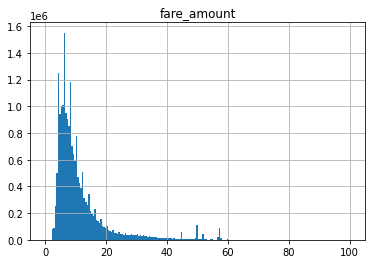

In [40]:
df_train.hist(column='fare_amount',bins=200)

Acercamos para un mejor análisis

(-76.0, -73.0)

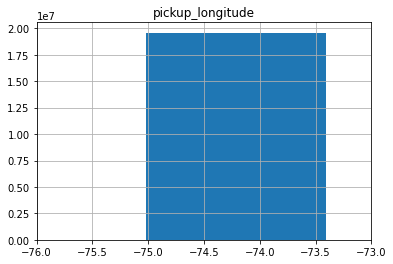

In [41]:
df_train.hist(column='pickup_longitude',bins=200)
#plot.ylim(0,1000)
plot.xlim(-76,-73)

In [42]:
len(df_train[df_train['pickup_longitude'] < -75].index)

1879

In [43]:
len(df_train[df_train['pickup_longitude'] >= -73.3].index)

400756

Observamos que la contración de datos se encuentras entre -75 y -73.

In [44]:
df_train = df_train[(df_train['pickup_longitude'] > -75) & (df_train['pickup_longitude'] <= -73.3)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef2ffe47d0>]],
      dtype=object)

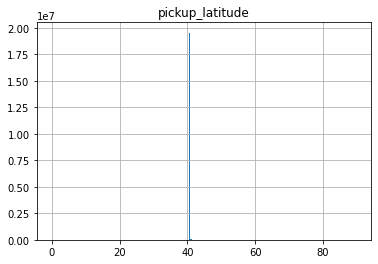

In [45]:
df_train.hist(column='pickup_latitude',bins=200)

Acercaremos para analizar mejor el gráfico.

(38.0, 45.0)

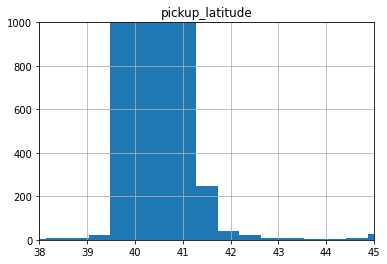

In [46]:
df_train.hist(column='pickup_latitude',bins=200)
plot.ylim(0,1000)
plot.xlim(38,45)

In [47]:
len(df_train[df_train['pickup_latitude'] < 39.5].index)

597

In [48]:
len(df_train[df_train['pickup_latitude'] > 42].index)

141

In [49]:
df_train = df_train[(df_train['pickup_latitude'] >=39 ) & (df_train['pickup_latitude'] <=42)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef2fe8e510>]],
      dtype=object)

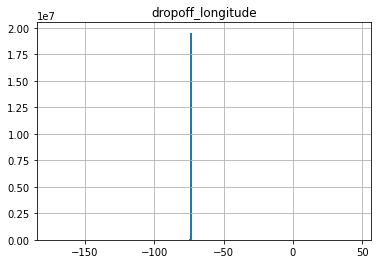

In [50]:
df_train.hist(column='dropoff_longitude',bins=200)

Acercamos para analizar mejor el gráfico

(-74.5, -72.5)

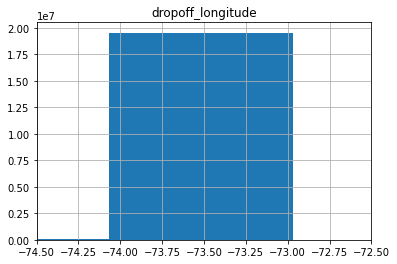

In [51]:
df_train.hist(column='dropoff_longitude',bins=200)

plot.xlim(-74.5,-72.5)

In [52]:
len(df_train[df_train['dropoff_longitude'] < -74.5].index)

1660

In [53]:
len(df_train[df_train['dropoff_longitude'] > -72.5].index)

18315

In [54]:
df_train = df_train[(df_train['dropoff_longitude'] >=-74.5 ) & (df_train['dropoff_longitude'] <=-72.5)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef30122e90>]],
      dtype=object)

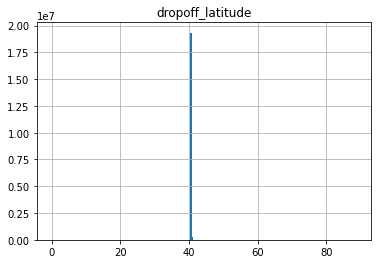

In [55]:
df_train.hist(column='dropoff_latitude',bins=200)

(40.0, 42.0)

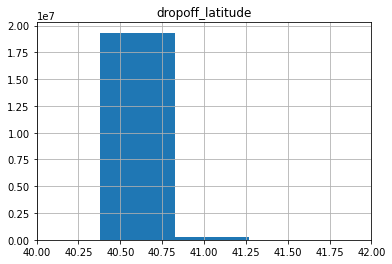

In [56]:
df_train.hist(column='dropoff_latitude',bins=200)
plot.xlim(40,42)

In [57]:
len(df_train[df_train['dropoff_latitude'] < 40.5].index)

3845

In [58]:
len(df_train[df_train['dropoff_latitude'] > 41].index)

2198

In [59]:
df_train = df_train[(df_train['dropoff_latitude'] >=40.5 ) & (df_train['dropoff_latitude'] <=41)]

In [60]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.956051e+07,1.956051e+07,1.956051e+07,1.956051e+07,1.956051e+07,1.956051e+07
mean,1.107852e+01,-7.748107e+01,4.390191e+01,-7.748083e+01,4.390209e+01,1.685486e+00
std,8.981473e+00,3.704508e+00,3.201914e+00,3.704509e+00,3.203002e+00,1.312283e+00
min,1.000000e-02,-7.499062e+01,3.900730e+01,-7.450000e+01,4.050003e+01,0.000000e+00
25%,6.000000e+00,-7.399229e+01,4.073655e+01,-7.399158e+01,4.073558e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075334e+01,-7.398061e+01,4.075385e+01,1.000000e+00
75%,1.250000e+01,-7.396835e+01,4.076751e+01,-7.396539e+01,4.076838e+01,2.000000e+00
max,1.000000e+02,-7.330000e+01,4.200000e+01,-7.251667e+01,4.099995e+01,2.080000e+02


In [61]:
len(df_train.index)

19560507

In [62]:
def distancia(df):
  # Radio medio de la tierra en Km
  R = 6371.0
  # Conversion a radianes
  lt1 = np.radians(df.pickup_latitude)
  lg1 = np.radians(df.pickup_longitude)
  lt2 = np.radians(df.dropoff_latitude)
  lg2 = np.radians(df.dropoff_longitude)
  # Defirencia entre latitudes y longitudes
  dlt = lt2 - lt1
  dlg = lg2 - lg1
  # Haversine
  hav = np.sin(dlt / 2)**2 + np.cos(lt1) * np.cos(lt2) * np.sin(dlg / 2)**2
  c = 2 * np.arctan2(np.sqrt(hav), np.sqrt(1-hav))
  d = R * c
  return d

In [63]:
df_train['distancia'] = distancia(df_train)

In [64]:
df_train = df_train.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])

Usando un tipo de dato eficiente para distancia.


In [65]:
df_train["distancia"] = pd.to_numeric(df_train["distancia"], downcast="float")

In [66]:
df_train[['distancia']].describe()

,distancia
count,1.956051e+07
mean,3.193972e+00
std,3.540420e+00
min,0.000000e+00
25%,1.253786e+00
50%,2.152556e+00
75%,3.906384e+00
max,1.970339e+02


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefa48868d0>]],
      dtype=object)

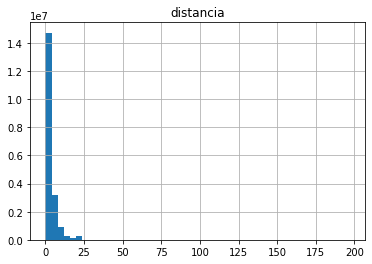

In [67]:
df_train.hist(column='distancia',bins=50)

(-5.0, 35.0)

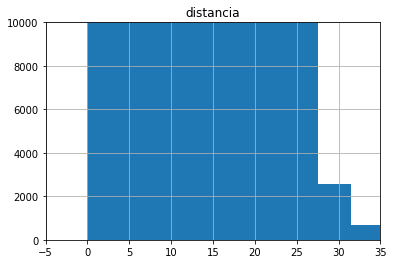

In [68]:
df_train.hist(column='distancia',bins=50)
plot.ylim(0,10000)
plot.xlim(-5,35)

In [69]:
len(df_train[df_train['distancia'] < 0].index)

0

In [70]:
len(df_train[df_train['distancia'] > 28].index)

4650

In [71]:
df_train = df_train[(df_train['distancia'] >0 ) & (df_train['distancia'] <28)]

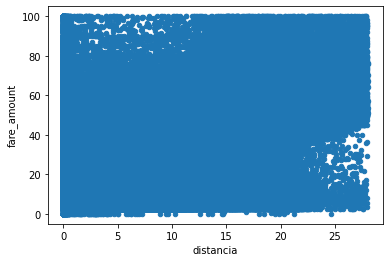

In [72]:
df_train.plot.scatter(x='distancia',
                               y='fare_amount')

# Analizando pickup_datetime

In [73]:
df_train['pickup_datetime']

0           2009-06-15 17:26:21 UTC
1           2010-01-05 16:52:16 UTC
2           2011-08-18 00:35:00 UTC
3           2012-04-21 04:30:42 UTC
4           2010-03-09 07:51:00 UTC
                     ...           
19999995    2013-10-16 17:49:00 UTC
19999996    2014-08-08 00:16:56 UTC
19999997    2009-10-10 22:14:00 UTC
19999998    2014-12-10 12:26:00 UTC
19999999    2010-08-13 14:15:00 UTC
Name: pickup_datetime, Length: 19350780, dtype: object

In [74]:
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.replace(" UTC", "")

In [75]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])

Usando tipos de dato eficientes para "año" , "mes" , "dia" , "hora" , para una reducción de memoria.

In [76]:
df_train['año'] = df_train.pickup_datetime.dt.year
df_train["año"] = pd.to_numeric(df_train["año"], downcast="unsigned")

df_train['mes'] = df_train.pickup_datetime.dt.month
df_train["mes"] = pd.to_numeric(df_train["mes"], downcast="unsigned")

In [77]:
df_train['dia'] = df_train.pickup_datetime.dt.day
df_train["dia"] = pd.to_numeric(df_train["dia"], downcast="unsigned")

df_train['hora'] = df_train.pickup_datetime.dt.hour
df_train["hora"] = pd.to_numeric(df_train["hora"], downcast="unsigned")

In [78]:
df_train = df_train.drop(columns=['pickup_datetime'])

In [79]:
df_train.head()

,fare_amount,passenger_count,distancia,año,mes,dia,hora
0,4.5,1,1.031069,2009,6,15,17
1,16.9,1,8.449763,2010,1,5,16
2,5.7,2,1.389644,2011,8,18,0
3,7.7,1,2.799485,2012,4,21,4
4,5.3,1,1.998886,2010,3,9,7


# Analizando Cantidad de pasajeros

In [80]:
df_train[['passenger_count']].describe()

,passenger_count
count,1.935078e+07
mean,1.685533e+00
std,1.311430e+00
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.080000e+02


Analizamos gráficamente la columna passenger_count.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef2fd99f10>]],
      dtype=object)

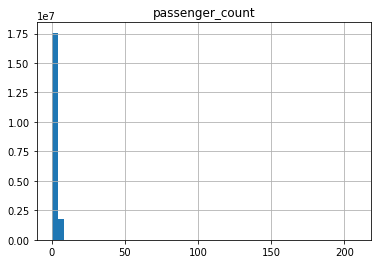

In [81]:
df_train.hist(column='passenger_count',bins=50)

Observamos una concentración de datos en los primeros valores positivos.

(0.0, 12.0)

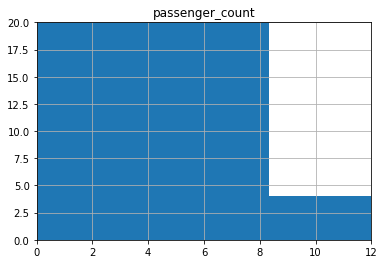

In [82]:
df_train.hist(column='passenger_count',bins=50)
plot.ylim(0,20)
plot.xlim(0,12)

Eliminamos la data que contenga cantidad de pasajeros mayor o igual a 8

In [83]:
df_train = df_train[0 < df_train['passenger_count']]

In [84]:
df_train = df_train[df_train['passenger_count'] < 8]

In [85]:
df_train[['passenger_count']].describe()

,passenger_count
count,1.928201e+07
mean,1.691502e+00
std,1.307033e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,7.000000e+00


Graficamos passenger_count después de reducir la data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef30bf21d0>]],
      dtype=object)

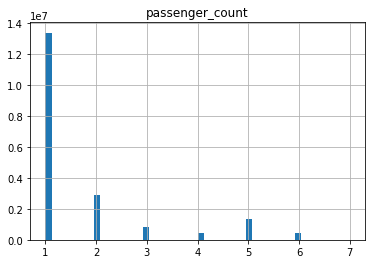

In [86]:
df_train.hist(column='passenger_count',bins=50)

In [87]:
len(df_train.index)

19282013

**Uso total de la memoria al final**

In [88]:
memoria_final2 = df_train.memory_usage(deep=True).sum()
print(f"{memoria_final2/1e9:0.2f}GB")

0.42GB


# Entrenamieto

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

predictors = ['passenger_count', 'distancia', 'año', 'mes', 'dia', 'hora']
salida = 'fare_amount'

X = df_train[predictors]
y = df_train[salida]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=22)

In [91]:
rf = RandomForestRegressor(n_estimators=500,
                            oob_score = True,
                            random_state=1,
                            max_depth=8)
rf.fit(X_train, y_train)

In [92]:
from joblib import dump, load
dump(rf, 'Modelo2.joblib')

In [95]:
rf = load('Modelo2.joblib')

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Metricas

In [96]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Conjunto de entrenamiento")
print(f'Error absoluto medio (MAE) : {mean_absolute_error(y_train, y_pred_train)}')
print(f'Error cuadrático medio (MSE) : {mean_squared_error(y_train, y_pred_train)}')
print(f'Raíz del Error Cuadrático Medio (RMSE) : {np.sqrt(mean_squared_error(y_train, y_pred_train))}')
print("Conjunto de pruebas")
print(f'Error absoluto medio (MAE) : {mean_absolute_error(y_test, y_pred_test)}')
print(f'Error cuadrático medio (MSE) : {mean_squared_error(y_test, y_pred_test)}')
print(f'Raíz del Error Cuadrático Medio (RMSE) : {np.sqrt(mean_squared_error(y_test, y_pred_test))}')

Conjunto de entrenamiento
Error absoluto medio (MAE) : 2.038225024976839
Error cuadrático medio (MSE) : 14.922581993031788
Raíz del Error Cuadrático Medio (RMSE) : 3.8629757950357115
Conjunto de pruebas
Error absoluto medio (MAE) : 2.038674872232533
Error cuadrático medio (MSE) : 14.97143933008489
Raíz del Error Cuadrático Medio (RMSE) : 3.8692944227707575
